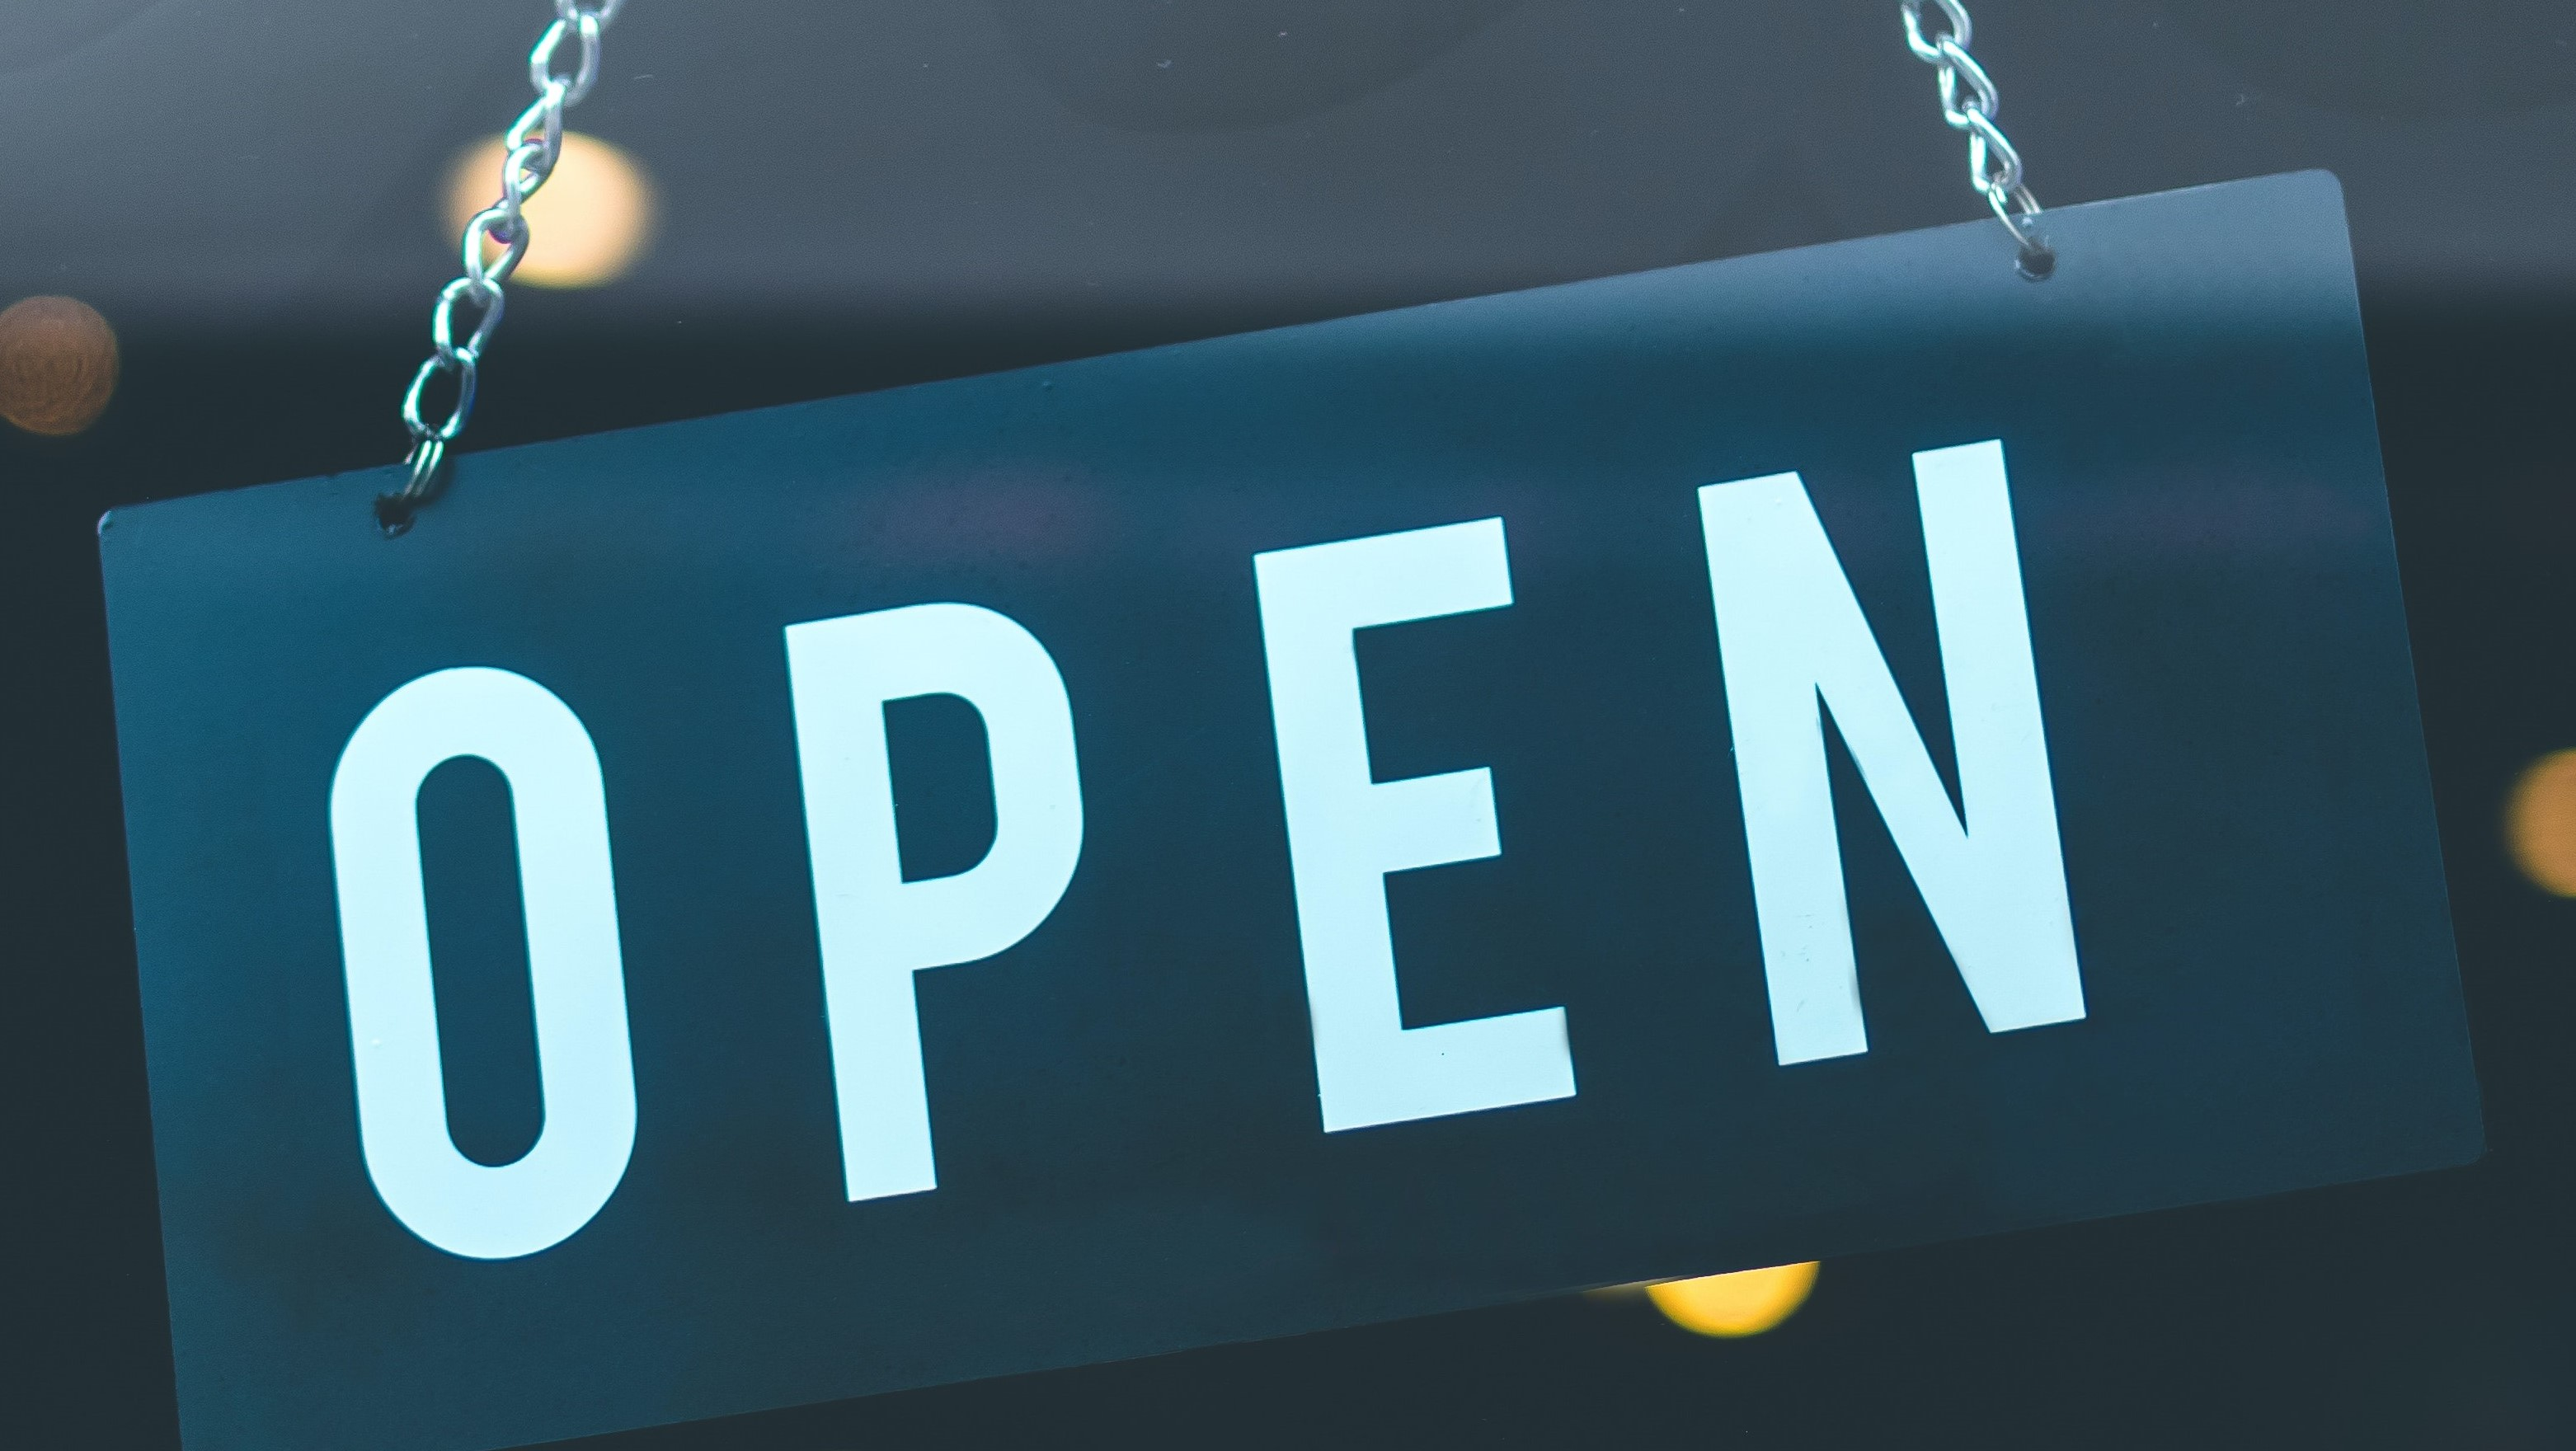

<a id = "1"></a><h1 id="Salary Prediction with Machine Learning"><span class="label label-default" style="background-color:#f5c0c0; font-size:30px; 
color: Black; ">Store Item Demand Forecasting</span></h1>
**This competition is provided as a way to explore different time series techniques on a relatively simple and clean dataset.**

**You are given 5 years of store-item sales data, and asked to predict 3 months of sales for 50 different items at 10 different stores.**



<a id = "1"></a><h1 id="Salary Prediction with Machine Learning"><span class="label label-default" style="background-color:#f5c0c0; font-size:30px; 
color: Black; ">Variables</span></h1>


- date
- store
- item
- sales



<a id = "1"></a><h1 id="Salary Prediction with Machine Learning"><span class="label label-default" style="background-color:#f5c0c0; font-size:30px; 
color: Black; ">Importing Libraries</span></h1>

In [1]:
# Gerekli Kütüphaneler ve Ayarlar

import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import seaborn as sns
import lightgbm as lgb
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
import itertools

import warnings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
warnings.filterwarnings('ignore')

<a id = "1"></a><h1 id="Salary Prediction with Machine Learning"><span class="label label-default" style="background-color:#f5c0c0; font-size:30px; 
color: Black; ">Exploring Data Analysis</span></h1>

In [2]:
#load dataset
train = pd.read_csv('../input/demand-forecasting-kernels-only/train.csv', parse_dates=['date'])
test = pd.read_csv('../input/demand-forecasting-kernels-only/test.csv', parse_dates=['date'])
df = pd.concat([train, test], sort=False) # veri önişleme için test ve train bir araya getirdim
df.head()

,date,store,item,sales,id
0,2013-01-01,1,1,13.0,NaN
1,2013-01-02,1,1,11.0,NaN
2,2013-01-03,1,1,14.0,NaN
3,2013-01-04,1,1,13.0,NaN
4,2013-01-05,1,1,10.0,NaN


In [3]:
print("Train setinin boyutu:",train.shape)
print("Test setinin boyutu:",test.shape)

Train setinin boyutu: (913000, 4)
Test setinin boyutu: (45000, 4)


In [4]:
df.shape

(958000, 5)

In [5]:
df.quantile([0, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99, 1]).T

,0.00,0.05,0.25,0.50,0.75,0.95,0.99,1.00
store,1.0,1.00,3.00,5.5,8.00,10.00,10.00,10.0
item,1.0,3.00,13.00,25.5,38.00,48.00,50.00,50.0
sales,0.0,16.00,30.00,47.0,70.00,107.00,135.00,231.0
id,0.0,2249.95,11249.75,22499.5,33749.25,42749.05,44549.01,44999.0


In [6]:
df["date"].min()

Timestamp('2013-01-01 00:00:00')

In [7]:
df["date"].max()

Timestamp('2018-03-31 00:00:00')

In [8]:
# Satış dağılımı
df["sales"].describe([0.10, 0.30, 0.50, 0.70, 0.80, 0.90, 0.95, 0.99])

count    913000.000000
mean         52.250287
std          28.801144
min           0.000000
10%          20.000000
30%          33.000000
50%          47.000000
70%          64.000000
80%          76.000000
90%          93.000000
95%         107.000000
99%         135.000000
max         231.000000
Name: sales, dtype: float64

In [9]:
# Mağaza sayısı
df["store"].nunique()

10

In [10]:
#Ürün sayısı
df["item"].nunique() 

50

In [11]:
# Her mağazadaki eşsiz ürün eşit sayıda mı?
df.groupby(["store"])["item"].nunique()

store
1     50
2     50
3     50
4     50
5     50
6     50
7     50
8     50
9     50
10    50
Name: item, dtype: int64

In [12]:
# Mağaza-ürün kırılımında satış istatistikleri
df.groupby(["store", "item"]).agg({"sales": ["sum", "mean", "median", "std"]})

sales                             
                 sum       mean median        std
store item                                       
1     1      36468.0  19.971522   19.0   6.741022
      2      97050.0  53.148959   52.0  15.005779
      3      60638.0  33.208105   33.0  10.072529
      4      36440.0  19.956188   20.0   6.640618
      5      30335.0  16.612815   16.0   5.672102
...              ...        ...    ...        ...
10    46    120601.0  66.046550   65.0  18.114991
      47     45204.0  24.755750   24.0   7.924820
      48    105570.0  57.814896   57.0  15.898538
      49     60317.0  33.032311   32.0  10.091610
      50    135192.0  74.037240   73.0  19.937566

[500 rows x 4 columns]

<a id = "1"></a><h1 id="Salary Prediction with Machine Learning"><span class="label label-default" style="background-color:#f5c0c0; font-size:30px; 
color: Black; ">Feature Engineering</span></h1>

In [13]:
# hangi ayda satış yapılmış
df['month'] = df.date.dt.month
# ayın hangi gününde satış yapılmış
df['day_of_month'] = df.date.dt.day
# yılın hangi gününde satış yapılmış
df['day_of_year'] = df.date.dt.dayofyear 
# yılın hangi haftasında satış yapılmış
df['week_of_year'] = df.date.dt.weekofyear
# haftanın hangi gününde satış yapılmış
df['day_of_week'] = df.date.dt.dayofweek
# hangi yılda satış yapılmış
df['year'] = df.date.dt.year
# haftasonu mu değil mi
df["is_wknd"] = df.date.dt.weekday // 4
# ayın başlangıcı mı
df['is_month_start'] = df.date.dt.is_month_start.astype(int)
# ayın bitişi mi
df['is_month_end'] = df.date.dt.is_month_end.astype(int) 

In [14]:
df.head()

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end
0,2013-01-01,1,1,13.0,NaN,1,1,1,1,1,2013,0,1,0
1,2013-01-02,1,1,11.0,NaN,1,2,2,1,2,2013,0,0,0
2,2013-01-03,1,1,14.0,NaN,1,3,3,1,3,2013,0,0,0
3,2013-01-04,1,1,13.0,NaN,1,4,4,1,4,2013,1,0,0
4,2013-01-05,1,1,10.0,NaN,1,5,5,1,5,2013,1,0,0


In [15]:
# store-item-month kırılımında satış istatistikleri
df.groupby(["store", "item", "month"]).agg({"sales": ["sum", "mean", "median", "std"]})

sales                             
                      sum       mean median        std
store item month                                      
1     1    1       2125.0  13.709677   13.0   4.397413
           2       2063.0  14.631206   14.0   4.668146
           3       2728.0  17.600000   17.0   4.545013
           4       3118.0  20.786667   20.0   4.894301
           5       3448.0  22.245161   22.0   6.564705
...                   ...        ...    ...        ...
10    50   8      13108.0  84.567742   85.0  15.676527
           9      11831.0  78.873333   79.0  15.207423
           10     11322.0  73.045161   72.0  14.209171
           11     11549.0  76.993333   77.0  16.253651
           12      8724.0  56.283871   56.0  11.782529

[6000 rows x 4 columns]

<a id = "1"></a><h1 id="Salary Prediction with Machine Learning"><span class="label label-default" style="background-color:#f5c0c0; font-size:30px; 
color: Black; ">Random Noise (Gürültü)</span></h1>

In [16]:
def random_noise(dataframe):
    return np.random.normal(scale=1.6, size=(len(dataframe),))

<a id = "1"></a><h1 id="Salary Prediction with Machine Learning"><span class="label label-default" style="background-color:#f5c0c0; font-size:30px; 
color: Black; ">Lag/Shifted Features (Gecikmeler)</span></h1>

In [17]:
df.sort_values(by=['store', 'item', 'date'], axis=0, inplace=True)
df.head()

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end
0,2013-01-01,1,1,13.0,NaN,1,1,1,1,1,2013,0,1,0
1,2013-01-02,1,1,11.0,NaN,1,2,2,1,2,2013,0,0,0
2,2013-01-03,1,1,14.0,NaN,1,3,3,1,3,2013,0,0,0
3,2013-01-04,1,1,13.0,NaN,1,4,4,1,4,2013,1,0,0
4,2013-01-05,1,1,10.0,NaN,1,5,5,1,5,2013,1,0,0


In [18]:
def lag_features(dataframe, lags):
    for lag in lags:
        dataframe['sales_lag_' + str(lag)] = dataframe.groupby(["store", "item"])['sales'].transform(
            lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe

df = lag_features(df, [91, 98, 105, 112, 119, 126, 182, 364, 546, 728])

<a id = "1"></a><h1 id="Salary Prediction with Machine Learning"><span class="label label-default" style="background-color:#f5c0c0; font-size:30px; 
color: Black; ">Rolling Mean Features (Hareketli Ortalamalar)</span></h1>

In [19]:
def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe['sales_roll_mean_' + str(window)] = dataframe.groupby(["store", "item"])['sales']. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()) + random_noise(
            dataframe)
    return dataframe


df = roll_mean_features(df, [365, 546, 730])

<a id = "1"></a><h1 id="Salary Prediction with Machine Learning"><span class="label label-default" style="background-color:#f5c0c0; font-size:30px; 
color: Black; ">Exponentially Weighted Mean Features (Üssel Ağırlıklı Ortalama Featureları)</span></h1>

In [20]:
def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["store", "item"])['sales'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe


alphas = [0.99, 0.95, 0.9, 0.8, 0.7, 0.5]
lags = [91, 98, 105, 112, 180, 270, 365, 546, 728]

df = ewm_features(df, alphas, lags)
df.tail()

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_365,sales_roll_mean_546,sales_roll_mean_730,sales_ewm_alpha_099_lag_91,sales_ewm_alpha_099_lag_98,sales_ewm_alpha_099_lag_105,sales_ewm_alpha_099_lag_112,sales_ewm_alpha_099_lag_180,sales_ewm_alpha_099_lag_270,sales_ewm_alpha_099_lag_365,sales_ewm_alpha_099_lag_546,sales_ewm_alpha_099_lag_728,sales_ewm_alpha_095_lag_91,sales_ewm_alpha_095_lag_98,sales_ewm_alpha_095_lag_105,sales_ewm_alpha_095_lag_112,sales_ewm_alpha_095_lag_180,sales_ewm_alpha_095_lag_270,sales_ewm_alpha_095_lag_365,sales_ewm_alpha_095_lag_546,sales_ewm_alpha_095_lag_728,sales_ewm_alpha_09_lag_91,sales_ewm_alpha_09_lag_98,sales_ewm_alpha_09_lag_105,sales_ewm_alpha_09_lag_112,sales_ewm_alpha_09_lag_180,sales_ewm_alpha_09_lag_270,sales_ewm_alpha_09_lag_365,sales_ewm_alpha_09_lag_546,sales_ewm_alpha_09_lag_728,sales_ewm_alpha_08_lag_91,sales_ewm_alpha_08_lag_98,sales_ewm_alpha_08_lag_105,sales_ewm_alpha_08_lag_112,sales_ewm_alpha_08_lag_180,sales_ewm_alpha_08_lag_270,sales_ewm_alpha_08_lag_365,sales_ewm_alpha_08_lag_546,sales_ewm_alpha_08_lag_728,sales_ewm_alpha_07_lag_91,sales_ewm_alpha_07_lag_98,sales_ewm_alpha_07_lag_105,sales_ewm_alpha_07_lag_112,sales_ewm_alpha_07_lag_180,sales_ewm_alpha_07_lag_270,sales_ewm_alpha_07_lag_365,sales_ewm_alpha_07_lag_546,sales_ewm_alpha_07_lag_728,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_98,sales_ewm_alpha_05_lag_105,sales_ewm_alpha_05_lag_112,sales_ewm_alpha_05_lag_180,sales_ewm_alpha_05_lag_270,sales_ewm_alpha_05_lag_365,sales_ewm_alpha_05_lag_546,sales_ewm_alpha_05_lag_728
44995,2018-03-27,10,50,NaN,44995.0,3,27,86,13,1,2018,0,0,0,38.992884,54.218863,64.692902,67.966195,66.896597,81.022592,80.835262,60.957443,100.173542,74.170332,87.093083,84.517633,81.831824,41.102494,53.993266,66.871500,67.862074,81.979884,112.096892,66.149794,96.496783,72.783196,41.561777,54.028375,66.387487,67.349358,81.895724,112.421502,66.744209,94.617783,71.979468,42.244368,54.197995,65.849785,66.785772,81.777579,112.682169,67.473304,92.561560,71.115472,43.955442,54.879654,64.996171,65.861563,81.488819,112.703381,68.859556,89.361543,69.838571,46.091666,55.909793,64.428121,65.144155,81.162051,112.055216,70.090358,87.248414,69.116907,51.309755,58.648702,64.033868,64.335072,80.828687,109.036310,71.734958,85.489012,68.933911
44996,2018-03-28,10,50,NaN,44996.0,3,28,87,13,2,2018,0,0,0,62.368080,51.490221,67.797075,60.941727,75.552865,82.592955,76.184226,72.269568,80.412905,69.418222,86.241319,85.699573,85.349212,62.781025,51.029933,66.998715,60.078621,89.919799,118.930969,60.061498,80.164968,68.047832,61.928089,51.151419,66.969374,60.367468,89.594786,118.671075,60.337210,80.730889,68.198973,60.924437,51.319799,66.884978,60.678577,89.177758,118.368217,60.747330,81.256156,68.311547,59.191088,51.775931,66.599234,61.172313,88.297764,117.740676,61.771911,81.872309,68.367714,57.927500,52.472938,66.228436,61.543247,87.348615,116.916565,63.027108,82.174524,68.335072,57.154878,54.824351,65.516934,62.167536,85.414343,114.018155,65.867479,82.744506,68.466956
44997,2018-03-29,10,50,NaN,44997.0,3,29,88,13,3,2018,0,0,0,60.042456,61.452937,71.293189,66.303693,75.166075,85.829395,81.274778,66.120371,97.596874,74.392796,87.586965,86.202025,82.723340,59.037810,62.880299,71.949987,65.940786,102.869198,119.989310,72.870615,98.811650,74.930478,59.146404,62.407571,71.748469,65.718373,102.329739,119.933554,72.366861,98.086544,74.659949,59.192444,61.831980,71.488498,65.467858,101.617776,119.836822,71.774733,97.225616,74.331155,59.038218,60.755186,70.919847,65.034463,100.059553,119.548135,70.754382,95.574462,73.673543,58.678250,59.841881,70.268531,64.662974,98.304585,119.074969,70.008132,93.952357,73.000522,58.077439,58.912176,68.758467,64.083768,94.207172,117.009078,69.433740,90.872253,71.733478
44998

In [21]:
#One-Hot Encoding

df = pd.get_dummies(df, columns=['day_of_week', 'month'])

In [22]:
#Converting sales to log(1+sales)

df['sales'] = np.log1p(df["sales"].values)

<a id = "1"></a><h1 id="Salary Prediction with Machine Learning"><span class="label label-default" style="background-color:#f5c0c0; font-size:30px; 
color: Black; ">LightGBM Model</span></h1>

In [23]:
# 2017'nin başına kadar (2016'nın sonuna kadar) train seti.
train = df.loc[(df["date"] < "2017-01-01"), :]

# 2017'nin ilk 3'ayı validasyon seti.
val = df.loc[(df["date"] >= "2017-01-01") & (df["date"] < "2017-04-01"), :]

# bağımsız değişkenler
cols = [col for col in train.columns if col not in ['date', 'id', "sales", "year"]]

In [24]:
# train seti için bağımlı değişkenin seçilmesi
Y_train = train['sales']

# train seti için bağımsız değişkenin seçilmesi
X_train = train[cols]

# validasyon seti için bağımlı değişkenin seçilmesi
Y_val = val['sales']

# validasyon seti için bağımsız değişkenin seçilmesi
X_val = val[cols] 

# kontrol
Y_train.shape, X_train.shape, Y_val.shape, X_val.shape

((730500,), (730500, 94), (45000,), (45000, 94))

<a id = "1"></a><h1 id="Salary Prediction with Machine Learning"><span class="label label-default" style="background-color:#f5c0c0; font-size:30px; 
color: Black; ">Custom Cost Function</span></h1>

In [25]:
def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num / denom)) / n
    return smape_val


def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return 'SMAPE', smape_val, False

In [26]:
# LightGBM parameters
lgb_params = {'metric': {'mae'},
              'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'num_boost_round': 10000, 
              'early_stopping_rounds': 200,
              'nthread': -1}

In [27]:
lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)
lgbval = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain, feature_name=cols)

model = lgb.train(lgb_params, lgbtrain,
                  valid_sets=[lgbtrain, lgbval],
                  num_boost_round=lgb_params['num_boost_round'],
                  early_stopping_rounds=lgb_params['early_stopping_rounds'],
                  feval=lgbm_smape, # hatyı gözlemliyoruz
                  verbose_eval=100)

y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)

# validasyon hatasının yüzdesi
smape(np.expm1(y_pred_val), np.expm1(Y_val))

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.375824 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.171476	training's SMAPE: 17.4894	valid_1's l1: 0.170666	valid_1's SMAPE: 17.4447
[200]	training's l1: 0.141267	training's SMAPE: 14.4696	valid_1's l1: 0.144915	valid_1's SMAPE: 14.8663
[300]	training's l1: 0.135706	training's SMAPE: 13.9126	valid_1's l1: 0.139878	valid_1's SMAPE: 14.361
[400]	training's l1: 0.133654	training's SMAPE: 13.7074	valid_1's l1: 0.138253	valid_1's SMAPE: 14.1983
[500]	training's l1: 0.132432	training's SMAPE: 13.585	valid_1's l1: 0.136843	valid_1's SMAPE: 14.0566
[600]	training's l1: 0.131589	training's SMAPE: 13.5004	valid_1's l1: 0.135846	valid_1's SMAPE: 13.9563
[700]	training's l1: 0.130971	training's SMAPE: 13.4384	valid_1's l1: 0.135079	valid_1's SMAPE: 13.8791
[800]	training's l1: 0.130518	training's SMAPE:

13.46534597540764

In [28]:
#Final Model

# test ve train bağımlı/bağımsız değişkenlerinin belirlenmesi

train = df.loc[~df.sales.isna()]
Y_train = train['sales']
X_train = train[cols]

test = df.loc[df.sales.isna()]
X_test = test[cols]

In [29]:
lgb_params = {'metric': {'mae'},
              'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'nthread': -1,
              "num_boost_round": model.best_iteration}

# LightGBM dataset
lgbtrain_all = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)

model = lgb.train(lgb_params, lgbtrain_all, num_boost_round=model.best_iteration)
test_preds = model.predict(X_test, num_iteration=model.best_iteration)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.467691 seconds.
You can set `force_col_wise=true` to remove the overhead.


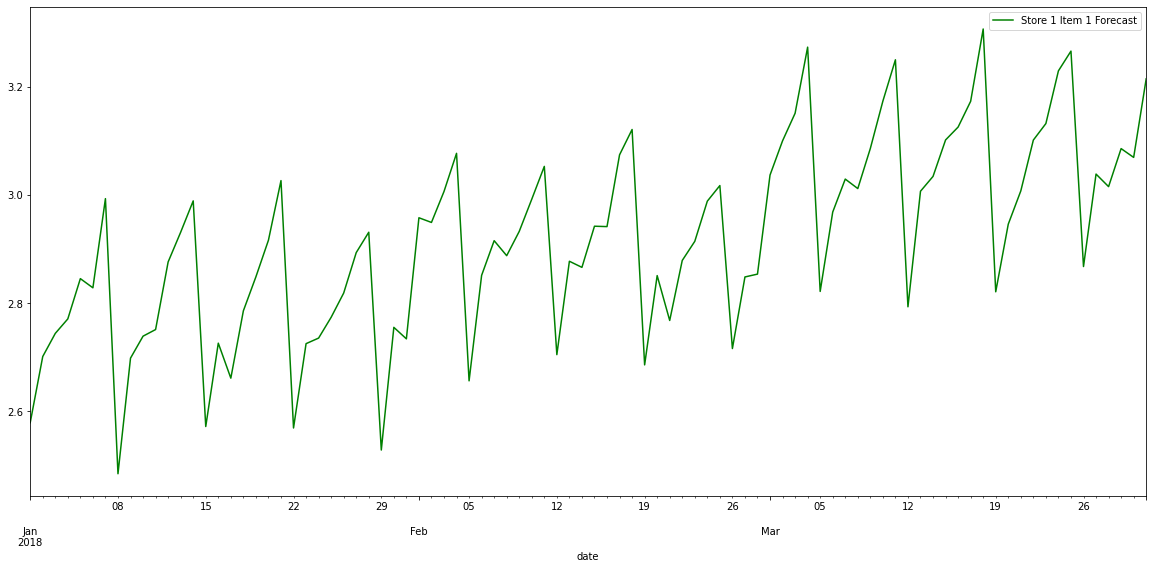

In [30]:
#1. mağazanın 1.ürünleri için yapılan tahminler

forecast = pd.DataFrame({"date":test["date"],
                        "store":test["store"],
                        "item":test["item"],
                        "sales":test_preds
                        })

forecast[(forecast.store == 1) & (forecast.item == 1)].set_index("date").sales.plot(color = "green",
                                                                                    figsize = (20,9),
                                                                                    legend=True, label = "Store 1 Item 1 Forecast");

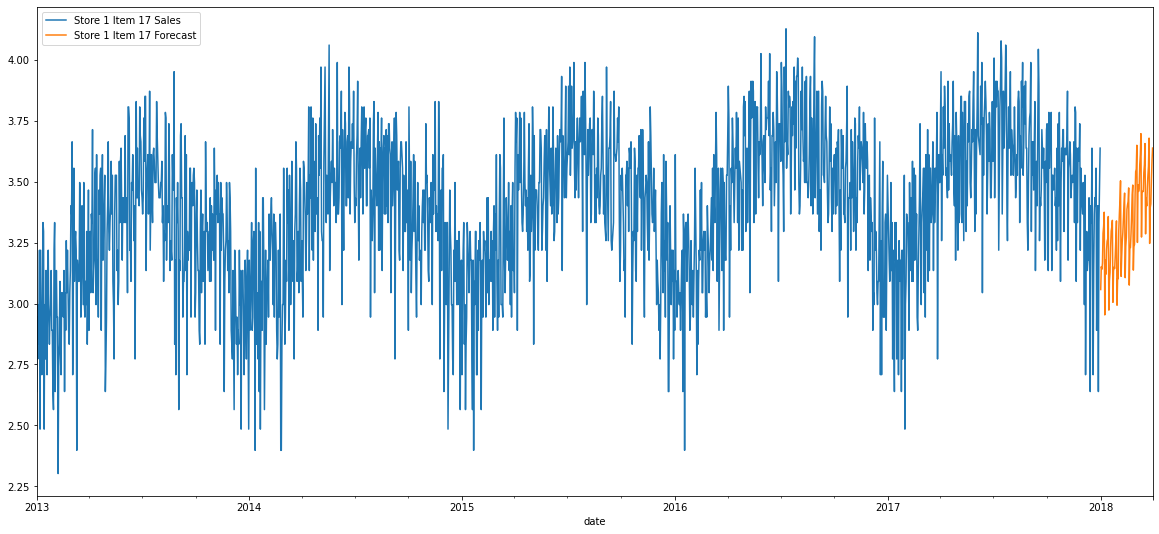

In [31]:
#1.Mağazanın 17. Ürünü İçin Tahmin Edilen Değerler

train[(train.store == 1) & (train.item == 17)].set_index("date").sales.plot(figsize = (20,9),legend=True, label = "Store 1 Item 17 Sales")
forecast[(forecast.store == 1) & (forecast.item == 17)].set_index("date").sales.plot(legend=True, label = "Store 1 Item 17 Forecast");

In [32]:
df.shape

(958000, 98)

<div style="display:fill;
            border-radius: false;
            border-style: solid;
            border-color:;
            border-style: false;
            border-width: 2px;
            color:;
            font-size:15px;
            font-family: Georgia;
            background-color:#ACCDA7;
            text-align:center;
            letter-spacing:0.1px;
            padding: 0.1em;">

**<h2>THANK YOU FOR TAKING THE TIME**